### Importando pacotes

In [43]:
using PortfolioOptCTG
using JuMP
using XLSX, DataFrames, Statistics, CSV
using LinearAlgebra
using HiGHS
using Plots
using StatsPlots

### Parâmetros do caso

In [44]:
param_caso = XLSX.readxlsx("Parametros.xlsx")["Parâmetros Caso"]

S = param_caso["F3"]; # Numero de cenários
T = param_caso["F6"]; # Numero de meses
tx = 0; # Custo oportunidade anual
tx_m = (1+tx)^(1/12) -1; # Custo oportunidade mensal
Solv = HiGHS.Optimizer # Solver
q = 1 / S .* ones(S); # Probabilidade dos cenarios

# Leitura do PLD Newave
file_PLD = string("./",param_caso["E9"])
PLD = Matrix(DataFrame(CSV.File(file_PLD;header=false)))'[:,:];

#Leitura número de horas no mês
file_h = string("./",param_caso["E12"])
h = Int.(Matrix(DataFrame(CSV.File(file_h;header=false)))[:,1]);

### Parâmetros contrato disponibilidade

In [45]:
param_usinas = XLSX.readxlsx("Parametros.xlsx")["Cadastro Usinas"]

usina = Vector() # Usinas do caso

if param_usinas["D5"] == 1
      push!(usina, "ARINOS")
end

if param_usinas["E5"] == 1
      push!(usina, "DIS")
end

if param_usinas["F5"] == 1
      push!(usina, "SDP")
end

if param_usinas["G5"] == 1
      push!(usina, "HYDRO")
end

nI = length(usina) # Número de usinas do caso
gu = zeros(S, T, nI) # Geração das usinas
C = ones(nI, T) # Custo de construção/manutenção por usina por mês
n = 1
GF = ones(nI)
ymax = ones(nI); # Porcentagem máxima da geração das usinas contratadas
ymin = zeros(nI); # Porcentagem minima da geração das usinas contratada


#Leitura geração usina ARINOS (% garantia física)
arinos = string("./",param_usinas["D11"])
gu_arinos = Matrix(DataFrame(CSV.File(arinos;header=false)))'[1:S,1:T];

#Leitura geração usina DIS (% garantia física)
dis = string("./",param_usinas["E11"])
gu_dis = Matrix(DataFrame(CSV.File(dis;header=false)))'[1:S,1:T];

#Leitura geração usina SDP (% garantia física)
sdp = string("./",param_usinas["F11"])
gu_sdp = Matrix(DataFrame(CSV.File(sdp;header=false)))'[1:S,1:T];

#Leitura geração usina DIS (% garantia física)
hydro = string("./",param_usinas["G11"])
gu_hydro = Matrix(DataFrame(CSV.File(hydro;header=false)))'[1:S,1:T];

if param_usinas["D5"] == 1
      C[n,:] .= param_usinas["D9"]
      GF[n] = param_usinas["D17"]
      gu[:,:,n] .= gu_arinos
      ymax[n] = param_usinas["D21"]/100
      ymin[n] = param_usinas["D25"]/100
      n +=1
end

if param_usinas["E5"] == 1
      C[n,:] .= param_usinas["E9"]
      GF[n] = param_usinas["E17"]
      gu[:,:,n] .= gu_dis
      ymax[n] = param_usinas["E21"]/100
      ymin[n] = param_usinas["E25"]/100
      n +=1
end

if param_usinas["F5"] == 1
      C[n,:] .= param_usinas["F9"]
      GF[n] = param_usinas["F17"]
      gu[:,:,n] .= gu_sdp
      ymax[n] = param_usinas["F21"]/100
      ymin[n] = param_usinas["F25"]/100
      n +=1
end

if param_usinas["G5"] == 1
      C[n,:] .= param_usinas["G9"]
      GF[n] = param_usinas["G17"]
      gu[:,:,n] .= gu_hydro
      ymax[n] = param_usinas["G21"]/100
      ymin[n] = param_usinas["G25"]/100
      n +=1
end

3

### Parâmetros contrato quantidade

In [46]:
param_contrato = XLSX.readxlsx("Parametros.xlsx")["Cadastro Contrato Quantidade"]

Q = ones(0,T)
P = ones(0,T)
xmax = ones(0)
xmin = zeros(0)
n=1

if param_contrato["D5"] == 1       # Contrato 1
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F8:Q8"]
     P[n,:] = param_contrato["F11:Q11"]
     xmin[n] = param_contrato["T7"]/100
     xmax[n] = param_contrato["T10"]/100
     n+=1
end

if param_contrato["D16"] == 1      # Contrato 2
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F19:Q19"]
     P[n,:] = param_contrato["F22:Q22"]
     xmin[n] = param_contrato["T18"]/100
     xmax[n] = param_contrato["T21"]/100
     n+=1
end

if param_contrato["D24"] == 1      # Contrato 3
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F27:Q27"]
     P[n,:] = param_contrato["F30:Q30"]
     xmin[n] = param_contrato["T26"]/100
     xmax[n] = param_contrato["T29"]/100
     n+=1
end

if param_contrato["D32"] == 1      # Contrato 4
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F35:Q35"]
     P[n,:] = param_contrato["F38:Q38"]
     xmin[n] = param_contrato["T34"]/100
     xmax[n] = param_contrato["T37"]/100
     n+=1
end

if param_contrato["D40"] == 1      # Contrato 5
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F43:Q43"]
     P[n,:] = param_contrato["F46:Q46"]
     xmin[n] = param_contrato["T42"]/100
     xmax[n] = param_contrato["T45"]/100
     n+=1
end

if param_contrato["D48"] == 1      # Contrato 6
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F51:Q51"]
     P[n,:] = param_contrato["F54:Q54"]
     xmin[n] = param_contrato["T50"]/100
     xmax[n] = param_contrato["T53"]/100
     n+=1
end

if param_contrato["D56"] == 1      # Contrato 7
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F59:Q59"]
     P[n,:] = param_contrato["F62:Q62"]
     xmin[n] = param_contrato["T58"]/100
     xmax[n] = param_contrato["T61"]/100
     n+=1
end

if param_contrato["D64"] == 1      # Contrato 8
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F67:Q67"]
     P[n,:] = param_contrato["F70:Q70"]
     xmin[n] = param_contrato["T66"]/100
     xmax[n] = param_contrato["T69"]/100
     n+=1
end

if param_contrato["D72"] == 1      # Contrato 9
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F75:Q75"]
     P[n,:] = param_contrato["F78:Q78"]
     xmin[n] = param_contrato["T74"]/100
     xmax[n] = param_contrato["T77"]/100
     n+=1
end

if param_contrato["D80"] == 1      # Contrato 10
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F83:Q83"]
     P[n,:] = param_contrato["F86:Q86"]
     xmin[n] = param_contrato["T82"]/100
     xmax[n] = param_contrato["T85"]/100
     n+=1
end

if param_contrato["D88"] == 1      # Contrato 11
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F91:Q91"]
     P[n,:] = param_contrato["F94:Q94"]
     xmin[n] = param_contrato["T90"]/100
     xmax[n] = param_contrato["T93"]/100
     n+=1
end

if param_contrato["D96"] == 1      # Contrato 12
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F99:Q99"]
     P[n,:] = param_contrato["F102:Q102"]
     xmin[n] = param_contrato["T98"]/100
     xmax[n] = param_contrato["T101"]/100
     n+=1
end

if param_contrato["D104"] == 1      # Contrato 13
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F107:Q107"]
     P[n,:] = param_contrato["F110:Q110"]
     xmin[n] = param_contrato["T106"]/100
     xmax[n] = param_contrato["T109"]/100
     n+=1
end

if param_contrato["D118"] == 1      # Contrato 14
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F121:Q121"]
     P[n,:] = param_contrato["F124:Q124"]
     xmin[n] = param_contrato["T120"]/100
     xmax[n] = param_contrato["T123"]/100
     n+=1
end

if param_contrato["D129"] == 1      # Contrato 15
     Q = vcat(Q, ones(T)')
     P = vcat(P, ones(T)')
     xmax = vcat(xmax,1)
     xmin = vcat(xmin,1)
     Q[n,:] = param_contrato["F132:Q132"]
     P[n,:] = param_contrato["F135:Q135"]
     xmin[n] = param_contrato["T131"]/100
     xmax[n] = param_contrato["T134"]/100
     n+=1
end

J = n-1

println(Q)
println(P)
println(xmax)
println(xmin)

[250.0 250.0 250.0 250.0 250.0 250.0 250.0 250.0 250.0 250.0 250.0 250.0; 100.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 50.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0; 100.0 250.0 0.0 250.0 0.0 338.0 100.0 700.0 100.0 338.0 100.0 338.0]
[108.0 

108.0 108.0 108.0 108.0 108.0 108.0 108.0 108.0 108.0 108.0 108.0; 100.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 60.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 100.0 0.0 0.0 0.0 0.0; 194.0 108.0 0.0 100.0 0.0 100.0 100.0 100.0 100.0 100.0 100.0 100.0]
[1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0]
[0.3, -0.5, 0.3, 0.0, 0.0, 0.0, -0.2]

### Parâmetros de aversão a risco

In [47]:
param_risco = XLSX.readxlsx("Parametros.xlsx")["Parâmetros de Risco"]

α = 0.01*param_risco["F3"] # Percentil CVaR Risco
flag_restricao = param_risco["F6"] # Boolean restrição receita minima
λ = 0.01*param_risco["F9"] # Reguçador de risco função objetivo
Rmin = ones(T)*(1e6)*param_risco["F12"]; # Receita minima

### EXPERIMENTO - Cootimização

In [48]:
params = ParametrosContratacao(; gu, GF, h, Q, PLD, α, T, λ, flag_restricao, Rmin, P, S, q, nI, J, C, tx_m, xmin, xmax, ymin, ymax, Solv)
Rdisp_otimo, Rquant_otimo, R_otimo, R_total_otimo, x_otimo, y_otimo = port_alloc(params);

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
16812 rows, 16810 cols, 94851 nonzeros
16809 rows, 16810 cols, 94840 nonzeros
Presolve : Reductions: rows 16809(-129621); columns 16810(-129600); elements 94840(-259229)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.5328746667e+05 Ph1: 16800(5.3142e+07); Du: 1201(253.287) 0s
      17894    -1.4237670987e+08 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 17894
Objective value     :  1.4237670987e+08
HiGHS run time      :          0.51


#### Resultados

In [49]:
x = zeros(15)
y = zeros(4)

m=1
if param_usinas["D5"] == 1
    println("Construção ótima ", usina[m],": ",GF[m]*y_otimo[m],"MW méd")
    y[1] = y_otimo[m]
    m+=1
else
    y[1] = 0
end
if param_usinas["E5"] == 1
    println("Construção ótima ", usina[m],": ",GF[m]*y_otimo[m],"MW méd")
    y[2] = y_otimo[m]
    m+=1
else
    y[2] = 0
end
if param_usinas["F5"] == 1
    println("Construção ótima ", usina[m],": ",GF[m]*y_otimo[m],"MW méd")
    y[3] = y_otimo[m]
    m+=1
else
    y[3] = 0
end
if param_usinas["G5"] == 1
    println("Construção ótima ", usina[m],": ",GF[m]*y_otimo[m],"MW méd")
    y[4] = y_otimo[m]
else
    y[4] = 0
end

n=1
if param_contrato["D5"] == 1
    println("Quantidade ótima A+1: ", Q[n]*x_otimo[n],"MW méd")
    x[1] = x_otimo[n]
    n+=1
else
    x[1] = 0
end
if param_contrato["D16"] == 1 
    println("Quantidade ótima M+1 - Jan: ", Q[n,1]*x_otimo[n],"MW méd")
    x[2] = x_otimo[n]
    n+=1
else
    x[2] = 0
end
if param_contrato["D24"] == 1 
    println("Quantidade ótima M+1 - Fev: ", Q[n,2]*x_otimo[n],"MW méd")
    x[3] = x_otimo[n]
    n+=1
else
    x[3] = 0
end
if param_contrato["D32"] == 1
    println("Quantidade ótima M+1 - Mar: ", Q[n,3]*x_otimo[n],"MW méd")
    x[4] = x_otimo[n]
    n+=1
else
    x[4] = 0
end
if param_contrato["D40"] == 1
    println("Quantidade ótima M+1 - Abr: ", Q[n,4]*x_otimo[n],"MW méd")
    x[5] = x_otimo[n]
    n+=1
else
    x[5] = 0
end
if param_contrato["D48"] == 1
    println("Quantidade ótima M+1 - Mai: ", Q[n,5]*x_otimo[n],"MW méd")
    x[6] = x_otimo[n]
    n+=1
else
    x[6] = 0
end
if param_contrato["D56"] == 1
    println("Quantidade ótima M+1 - Jun: ", Q[n,6]*x_otimo[n],"MW méd")
    x[7] = x_otimo[n]
    n+=1
else
    x[7] = 0
end
if param_contrato["D64"] == 1
    println("Quantidade ótima M+1 - Jul: ", Q[n,7]*x_otimo[n],"MW méd")
    x[8] = x_otimo[n]
    n+=1
else
    x[8] = 0
end
if param_contrato["D72"] == 1
    println("Quantidade ótima M+1 - Ago: ", Q[n,8]*x_otimo[n],"MW méd")
    x[9] = x_otimo[n]
    n+=1
else
    x[9] = 0
end
if param_contrato["D80"] == 1
    println("Quantidade ótima M+1 - Set: ", Q[n,9]*x_otimo[n],"MW méd")
    x[10] = x_otimo[n]
    n+=1
else
    x[10] = 0
end
if param_contrato["D88"] == 1
    println("Quantidade ótima M+1 - Out: ", Q[n,10]*x_otimo[n],"MW méd")
    x[11] = x_otimo[n]
    n+=1
else
    x[11] = 0
end
if param_contrato["D96"] == 1
    println("Quantidade ótima M+1 - Nov: ", Q[n,11]*x_otimo[n],"MW méd")
    x[12] = x_otimo[n]
    n+=1
else
    x[12] = 0
end
if param_contrato["D104"] == 1
    println("Quantidade ótima M+1 - Dez: ", Q[n,12]*x_otimo[n],"MW méd")
    x[13] = x_otimo[n]
    n+=1
else
    x[13] = 0
end
if param_contrato["D118"] == 1
    println("Quantidade ótima - Genérico: ", Q[n]*x_otimo[n],"MW méd")
    x[14] = x_otimo[n]
    n+=1
else
    x[14] = 0
end
if param_contrato["D129"] == 1
    println("Quantidade ótima - Genérico: ", Q[n]*x_otimo[n],"MW méd")
    x[15] = x_otimo[n]
else
    x[15] = 0
end

println("% Contratação: ", x_otimo)

Construção ótima DIS: 100.0MW méd
Construção ótima HYDRO: 200.0MW méd
Quantidade ótima A+1: 250.0MW méd
Quantidade ótima M+1 - Jan: -50.0MW méd
Quantidade ótima M+1 - Abr: 15.0MW méd
Quantidade ótima M+1 - Jun: -0.0MW méd
Quantidade ótima M+1 - Jul: 27.00554229583103MW méd


Quantidade ótima M+1 - Ago: -0.0MW méd
Quantidade ótima - Genérico: 7.142857142857142MW méd
% Contratação: [1.0, -0.5, 0.3, -0.0, 0.2700554229583103, -0.0, 0.07142857142857142]


In [50]:
out_Receita = DataFrame(R_otimo',:auto);
out_path = string("Receita.csv");
CSV.write(out_path,out_Receita, writeheader = false);

In [51]:
XLSX.openxlsx("Parametros.xlsx", mode="rw") do xf
    sheet = xf[5];
    sheet["A2"] = Statistics.mean(R_otimo'/1e6, dims = 2);
    sheet["B2"] = Statistics.mean(cvar_mensal'/1e6, dims = 2);
    sheet["E2",dim=1] = x;
    sheet["H2",dim=1] = y;
end;

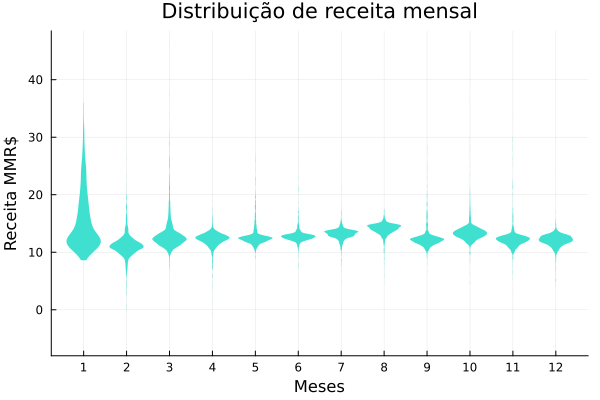

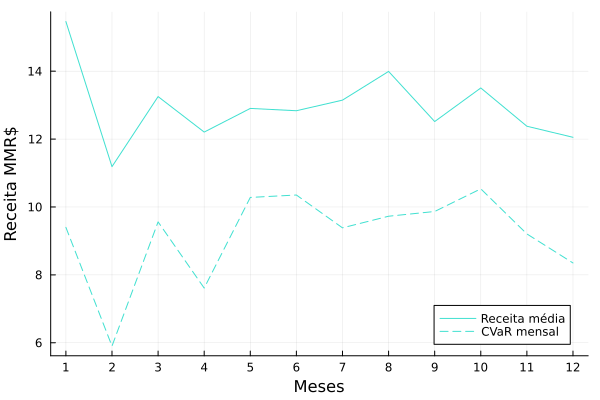

In [52]:
media_meses = Statistics.mean(R_otimo, dims = 1)
cvar_mensal =
    (Statistics.mean(sort(R_otimo, dims = 1)[1:Int(round((1 - α) * S)), :], dims = 1));

meses = collect(1:1:T);


c01 = Plots.violin(
    meses[1:12]',
    R_otimo/1e6,
    color = :turquoise,
    title = "Distribuição de receita mensal",
    legend = false,
    xlabel = "Meses",
    ylabel = "Receita MMR\$",
    xticks = 1:1:12,
    linecolor = nothing,
);

c1m = plot(
    media_meses'/1e6,
    color = :turquoise,
    label = "Receita média",
    xticks = 1:1:12,
    xlabel = "Meses",
    ylabel = "Receita MMR\$",
    legend = :bottomright
)
c1m = plot!(cvar_mensal'/1e6, color = :turquoise, line = :dash, label = "CVaR mensal")

display(c01)
display(c1m)